In [1]:
# Package imports
import numpy as np
from sklearn.model_selection import train_test_split

# Matplotlib is a matlab like plotting library
import matplotlib
from matplotlib import pyplot as plt
# SciKitLearn is a useful machine learning utilities library
import sklearn
# The sklearn dataset module helps generating |datasets
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from scipy.stats import gaussian_kde

In [2]:
# importing dataset
# import data
from DataExtraction import dataNoMass
from DataExtraction import dataWithP2
from DataExtraction import dataWithP2E2 
from DataExtraction import dataWithMass 
from DataExtraction import p2E2 
from DataExtraction import p2NegE2 as data
#from DataExtraction import labels
from DataExtraction import labels2D as labels
data = np.array(data)
labels = np.array(labels)

In [3]:
# split data 
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.5, test_size=0.5, random_state=42)

In [4]:
# normalize test data
# train_data[:,0] = train_data[:,0] / np.linalg.norm(train_data[:,0]) # normalize column 0
# train_data[:,1] = train_data[:,1] / np.linalg.norm(train_data[:,1]) # normalize column 1
#normalize train data
# test_data[:,0] = test_data[:,0] / np.linalg.norm(test_data[:,0]) # normalize column 0
# test_data[:,1] = test_data[:,1] / np.linalg.norm(test_data[:,1]) # normalize column 1

In [5]:
runSum = 0
for e in train_data:
    runSum+=e
avgE2 = runSum/(len(train_data))

In [6]:
train_data = train_data/avgE2
test_data = test_data/avgE2

In [7]:
# messing with the number of training data points
# train_data = train_data[0:9]
# train_labels = train_labels[0:9]

In [8]:
# Now we define all our functions

def softmax(z):
    #Calculate exponent term first
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# loss functions
def softmax_loss(y,y_hat):
    # Clipping value
    minval = 0.000000000001
    # Number of samples
    m = y.shape[0]
    # Loss formula, note that np.sum sums up the entire matrix and therefore does the job of two sums from the formula
    loss = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)))
    #loss = -1/m * np.sum(y * np.log(y_hat))
    return loss

def crossEntropy_loss(y, y_hat):
    m = y.shape[0]
    if y.all() == 1:
        return -1/m * np.sum(np.log(y_hat))
    else:
        return -1/m * np.sum(np.log(1 - y_hat))

def mse_loss(y, y_hat):
    m = y.shape[0]
    return np.sum((y_hat - y)**2) / m
    
def loss_derivative(y,y_hat):
    return (y_hat-y)

def tanh_derivative(x):
    return (1 - np.power(x, 2))

# This is the forward propagation function
def forward_prop(model,a0):
    
    #Start Forward Propagation
    
    # Load parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'],model['b3']
    
    # Do the first Linear step 
    # Z1 is the input layer x times the dot product of the weights + our bias b
    z1 = a0.dot(W1) + b1
    
    # Put it through the first activation function
    a1 = np.tanh(z1)
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = np.tanh(z2)
    
    #Third linear step
    z3 = a2.dot(W3) + b3
    
    #For the Third linear activation function we use the softmax function, either the sigmoid of softmax should be used for the last layer
    a3 = softmax(z3)
    
    #Store all results in these values
    cache = {'a0':a0,'z1':z1,'a1':a1,'z2':z2,'a2':a2,'a3':a3,'z3':z3}
    return cache

# This is the BACKWARD PROPAGATION function
def backward_prop(model,cache,y):

    # Load parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'],model['W3'],model['b3']
    # Load forward propagation results
    a0,a1, a2,a3 = cache['a0'],cache['a1'],cache['a2'],cache['a3']
    
    # Get number of samples
    m = y.shape[0]
    
    # Calculate loss derivative with respect to output
    dz3 = loss_derivative(y=y,y_hat=a3)

    # Calculate loss derivative with respect to second layer weights
    dW3 = 1/m*(a2.T).dot(dz3) #dW2 = 1/m*(a1.T).dot(dz2) 
    
    # Calculate loss derivative with respect to second layer bias
    db3 = 1/m*np.sum(dz3, axis=0)
    
    # Calculate loss derivative with respect to first layer
    dz2 = np.multiply(dz3.dot(W3.T) ,tanh_derivative(a2))
    
    # Calculate loss derivative with respect to first layer weights
    dW2 = 1/m*np.dot(a1.T, dz2)
    
    # Calculate loss derivative with respect to first layer bias
    db2 = 1/m*np.sum(dz2, axis=0)
    
    dz1 = np.multiply(dz2.dot(W2.T),tanh_derivative(a1))
    
    dW1 = 1/m*np.dot(a0.T,dz1)
    
    db1 = 1/m*np.sum(dz1,axis=0)
    
    # Store gradients
    grads = {'dW3':dW3, 'db3':db3, 'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return grads

#TRAINING PHASE
def initialize_parameters(nn_input_dim,nn_hdim,nn_output_dim):
    # First layer weights
    W1 = 2 *np.random.randn(nn_input_dim, nn_hdim) - 1
    
    # First layer bias
    b1 = np.zeros((1, nn_hdim))
    
    # Second layer weights
    W2 = 2 * np.random.randn(nn_hdim, nn_hdim) - 1
    
    # Second layer bias
    b2 = np.zeros((1, nn_hdim))
    W3 = 2 * np.random.rand(nn_hdim, nn_output_dim) - 1
    b3 = np.zeros((1,nn_output_dim))
    
    
    # Package and return model
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,'W3':W3,'b3':b3}
    return model

def update_parameters(model,grads,learning_rate):
    # Load parameters
    W1, b1, W2, b2,b3,W3 = model['W1'], model['b1'], model['W2'], model['b2'],model['b3'],model["W3"]
    
    # Update parameters
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    W3 -= learning_rate * grads['dW3']
    b3 -= learning_rate * grads['db3']
    
    # load parameters into running lists
    w1s.append(W1) # modifies global list
    w2s.append(W2) # modifies global list
    w3s.append(W3) # modifies global list
    b1s.append(b1) # modifies global list
    b2s.append(b2) # modifies global list
    b3s.append(b3) # modifies global list
    
    # Store and return parameters
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3':W3,'b3':b3}
    return model
def predict(model, x):
    # Do forward pass
    c = forward_prop(model,x)
    #get y_hat
    y_hat = c['a3']
    # plotArr.append([x, y_hat]) #added to make plot
    return y_hat
def calc_accuracy(model,x,y):
    # Get total number of examples
    m = y.shape[0]
    # Do a prediction with the model
    pred = predict(model,x)
    # Ensure prediction and truth vector y have the same shape
    pred = pred.reshape(y.shape)
    # Calculate the number of wrong examples
    error = np.sum(np.abs(pred-y))
    # Calculate accuracy
    return (m - error)/m * 100
def train(model,X_,y_,learning_rate, epochs=2001, print_loss=False):
    # Gradient descent. Loop over epochs
    for i in range(0, epochs):

        # Forward propagation
        cache = forward_prop(model,X_)
        #a1, probs = cache['a1'],cache['a2']
        # Backpropagation
        
        grads = backward_prop(model,cache,y_)
        # Gradient descent parameter update
        # Assign new parameters to the model
        model = update_parameters(model=model,grads=grads,learning_rate=learning_rate)
        # it is at this point in the training that the weights get added to the lists
    
        a3 = cache['a3']
        thisLoss = mse_loss(y_,a3) # set loss function here
        losses.append(thisLoss) # modifies global list
        y_hat = predict(model,X_) # getting rid of this because it's wrong
        y_true = y_.argmax(axis=1)
        accur = accuracy_score(a3,train_labels)
        train_accuracies.append(accur) # modifies global list
        
        if i % 50 == 0:
            placeholderVar = accuracy_score(a3, train_labels)
            test_accuracy = accuracyOfModel(model, test_data, test_labels)
            test_accuracies.append(test_accuracy) # modifies global list
            test_num.append(i)
        #Printing loss & accuracy every 100 iterations
        if print_loss and i % 300==0:
            print('Loss after iteration',i,':',thisLoss)
            print('Train Accuracy after iteration',i,':',accur*100,'%')
            print('Test Accuracy after iteration',i,':',test_accuracy*100,'%')
    return model

# TESTING PHASE
# test the accuracy of any model
def accuracyOfModel(_model, _testData, _testLabels):
    y_pred = predict(_model,_testData) # make predictions on test data
    y_true = _testLabels # get usable info from labels
    return accuracy_score(y_pred, y_true)

def accuracy_score(_outputNodes, _labels):
    for i in range(len(_outputNodes)-1):
        if _outputNodes[i][0]>.5:
            _outputNodes[i]=[1,0]
        else:
            _outputNodes[i]=[0,1]
    numWrong = np.count_nonzero(np.subtract(_outputNodes,_labels))/2
    return (len(_outputNodes)-numWrong)/len(_outputNodes)

    

In [9]:
# plotArr = []
losses = []
train_accuracies = []
test_accuracies = []
test_num = []
w1s = []
w2s = []
w3s = []
b1s = []
b2s = []
b3s = []

np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(nn_input_dim=2, nn_hdim= 5, nn_output_dim= 2)
model = train(model,train_data,train_labels,learning_rate=0.01,epochs=2201,print_loss=True)

Loss after iteration 0 : 0.5001367476367664
Train Accuracy after iteration 0 : 50.71679603549847 %
Test Accuracy after iteration 0 : 50.772420419205574 %
Loss after iteration 300 : 0.5000407579725431
Train Accuracy after iteration 300 : 50.91400975955096 %
Test Accuracy after iteration 300 : 50.78506232459357 %
Loss after iteration 600 : 0.5000405336026662
Train Accuracy after iteration 600 : 50.92159490278375 %
Test Accuracy after iteration 600 : 50.78759070567116 %
Loss after iteration 900 : 0.5000403108178189
Train Accuracy after iteration 900 : 50.92918004601653 %
Test Accuracy after iteration 900 : 50.79517584890395 %
Loss after iteration 1200 : 0.5000400896060012
Train Accuracy after iteration 1200 : 50.94435033248212 %
Test Accuracy after iteration 1200 : 50.80023261105914 %
Loss after iteration 1500 : 0.5000398699553112
Train Accuracy after iteration 1500 : 50.9494070946373 %
Test Accuracy after iteration 1500 : 50.80781775429193 %
Loss after iteration 1800 : 0.5000396518539444

Text(0, 0.5, 'Score')

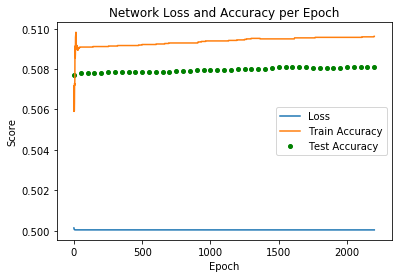

In [10]:
plt.plot(losses, label="Loss")
plt.plot(train_accuracies, label="Train Accuracy")
plt.scatter(test_num, test_accuracies, label="Test Accuracy", s=16, color="green")
plt.legend()
plt.title("Network Loss and Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")

In [11]:
plt.plot(w1s, label="W1")
plt.plot(w1s, label="W1")
plt.plot(w1s, label="W1")


[0.00762933 0.00763237]
[0.00829819 0.00820541]
[0.00082987 0.00073298]
[0.00214199 0.00214477]
[0.00388967 0.00379446]
[0.00192198 0.0019235 ]
[0.00866006 0.00856749]
[0.00347247 0.00347518]
[0.00778678 0.00779351]
[0.00802254 0.00792961]
39551


[[0.49496443 0.50503557]]
[[0.49429246 0.50570754]]
[[0.50583482 0.49416518]]
[[0.50343522 0.49656478]]
[[0.501107 0.498893]]
[[0.50377945 0.49622055]]
[[0.493733 0.506267]]
[[0.50138231 0.49861769]]
[[0.49470746 0.50529254]]
[[0.49471861 0.50528139]]


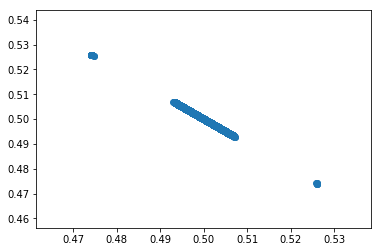

In [12]:
# get weights and biases
W1, b1, W2, b2,b3,W3 = model['W1'], model['b1'], model['W2'], model['b2'],model['b3'],model["W3"]

diffArray = []

plotX = []
plotY = []

inputArr = []
outputArr = []
for i in range(len(test_data)-1):
    _a0 = test_data[i]
    #print(_a0, _a0[1]-_a0[0])
    diffArray.append(_a0[1]-_a0[0])
    inputArr.append(_a0[1])
    _z1 = _a0.dot(W1) + b1
    # Put it through the first activation function
    _a1 = np.tanh(_z1)
    # Second linear step
    _z2 = _a1.dot(W2) + b2
    # Second activation function
    _a2 = np.tanh(_z2)
    #Third linear step
    _z3 = _a2.dot(W3) + b3
    #For the Third linear activation function we use the softmax function, either the sigmoid of softmax should be used for the last layer
    _a3 = softmax(_z3)
    if(i<10):
        print(_a3)
    plotX.append(_a3[0][0])
    plotY.append(_a3[0][1])
plt.scatter(plotX, plotY)
    # Calculate the point density
#     xy = np.vstack([plotX,plotY])
#     z = gaussian_kde(xy)(xy)

#     fig, ax = plt.subplots()
#     ax.scatter(x, y, c=z, s=100, edgecolor='')
#     plt.show()

#plt.hist(diffArray, bins=500)


0 lost muons


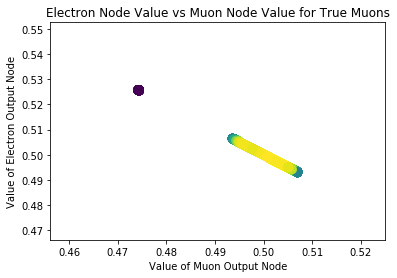

In [13]:
# plot muons, this doesn't work right now and we have no idea why
muonX = [] # value of "muon" output node
muonY = [] # value of "electron" output node
mCount = 0
for x, y, l in zip(plotX, plotY, test_labels):
    if l[0]==1:
        mCount +=1
        if(np.isnan(x) or np.isnan(y) or np.isinf(x) or np.isinf(y)or x<0 or y<0)!=True:
            muonX.append(x)
            muonY.append(y)
print(mCount-len(muonX), "lost muons")
# Calculate the point density
muon_xy = np.vstack([muonX,muonY])
muon_z = gaussian_kde(muon_xy)(muon_xy)

fig, ax = plt.subplots()
ax.scatter(muonX, muonY, c=muon_z, s=100, edgecolor='')
plt.title("Electron Node Value vs Muon Node Value for True Muons")
plt.xlabel("Value of Muon Output Node")
plt.ylabel("Value of Electron Output Node")
plt.show()
#plt.scatter(muonX, muonY)        

0 lost electrons


/Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/scipy/stats/kde.py:514: RuntimeWarning: invalid value encountered in sqrt
  self._norm_factor = sqrt(linalg.det(2*pi*self.covariance)) * self.n


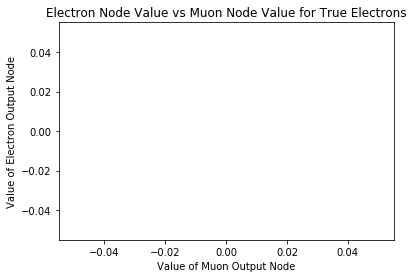

In [14]:
# plot electrons
eleX = [] # value of "muon" output node
eleY = [] # value of "electron" output node
eCount = 0
for x, y, l in zip(plotX, plotY, test_labels):
    if l[0]==0:
        eCount +=1
        if(np.isnan(x) or np.isnan(y) or np.isinf(x) or np.isinf(y) or x<0 or y<0)!=True:
            eleX.append(x)
            eleY.append(y)
print(eCount-len(eleX), "lost electrons")
# Calculate the point density
ele_xy = np.vstack([eleX,eleY])
ele_z = gaussian_kde(ele_xy)(ele_xy)

fig, ax = plt.subplots()
ax.scatter(eleX, eleY, c=ele_z, s=100, edgecolor='')
plt.title("Electron Node Value vs Muon Node Value for True Electrons")
plt.xlabel("Value of Muon Output Node")
plt.ylabel("Value of Electron Output Node")
plt.show()

0 differences greater than .75


Text(0.5, 1.0, 'Difference in Electron and Muon Output Node Values (E-M)')

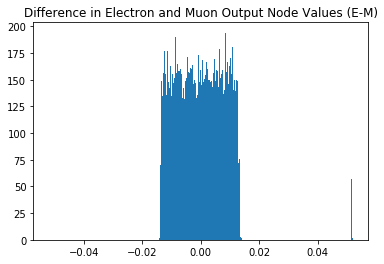

In [15]:
diffArr = []
discardedVals = 0
for x, y in zip(plotX, plotY):
    if(abs(y-x)<.75):
        diffArr.append(y-x)
    else:
        discardedVals += 1
print(discardedVals, "differences greater than .75")
plt.hist(diffArr, bins=1000)
plt.title("Difference in Electron and Muon Output Node Values (E-M)")

In [16]:
# make some models with different numbers of epochs
print("model 200")
model_200 = initialize_parameters(nn_input_dim=2, nn_hdim= 5, nn_output_dim= 2)
model_200 = train(model_200,train_data,train_labels,learning_rate=0.01,epochs=201,print_loss=True)
# model_300 = initialize_parameters(nn_input_dim=2, nn_hdim= 5, nn_output_dim= 2)
# model_300 = train(model_300,train_data,train_labels,learning_rate=0.01,epochs=301,print_loss=True)
print("model 400")
model_400 = initialize_parameters(nn_input_dim=2, nn_hdim= 5, nn_output_dim= 2)
model_400 = train(model_400,train_data,train_labels,learning_rate=0.01,epochs=401,print_loss=True)
# model_500 = initialize_parameters(nn_input_dim=2, nn_hdim= 5, nn_output_dim= 2)
# model_500 = train(model_500,train_data,train_labels,learning_rate=0.01,epochs=501,print_loss=True)

model 200
Loss after iteration 0 : 0.5224200504467356
Train Accuracy after iteration 0 : 50.0012641905388 %
Test Accuracy after iteration 0 : 50.307198300927915 %
model 400
Loss after iteration 0 : 0.5029193001876582
Train Accuracy after iteration 0 : 50.0012641905388 %
Test Accuracy after iteration 0 : 50.11504133903062 %
Loss after iteration 300 : 0.5007030699765981
Train Accuracy after iteration 300 : 49.85967485019342 %
Test Accuracy after iteration 300 : 49.95069656898688 %


In [17]:
print("Model 200 accuracy: ", accuracyOfModel(model_200, test_data, test_labels))
print("Model 400 accuracy: ", accuracyOfModel(model_400, test_data, test_labels))

Model 200 accuracy:  0.501883643902809
Model 400 accuracy:  0.4995069656898688
